# Drzewa decyzyjne

In [3]:
from sklearn.datasets import make_classification, make_moons
import pandas as pd
import math
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from ucimlrepo import fetch_ucirepo
import time
from sklearn.model_selection import GridSearchCV

In [2]:
def metrics(y_true, y_pred):
    print('accuracy:', accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print('sensitivity:', recall_score(y_true, y_pred))
    print('specificity:', cm[0][0]/(cm[0][0]+cm[0][1]))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

In [3]:
def surface(classifier, xi, yi):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)

    X, Y = np.meshgrid(x,y)
    Z = []

    for i in range(len(X)):
        for j in range(len(Y)):
            Z.append(classifier.predict(np.array([X[i,j], Y[i,j]]).reshape(1, -1)))
                    
    Z = np.reshape(Z, X.shape)
        
    plt.scatter(xi[yi==0,0], xi[yi==0,1], label='Klasa 0')
    plt.scatter(xi[yi==1,0], xi[yi==1,1], label='Klasa 1')
    plt.legend()
    plt.contourf(X, Y, Z, alpha=0.3)
    plt.show()


## Generowanie zbiorów

In [5]:
x1, y1 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
x2, y2 = make_moons(n_samples=2548, random_state=254448, shuffle=True)
x3, y3 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, random_state=254448, stratify=y1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, random_state=254448, stratify=y2)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, random_state=254448, stratify=y3)

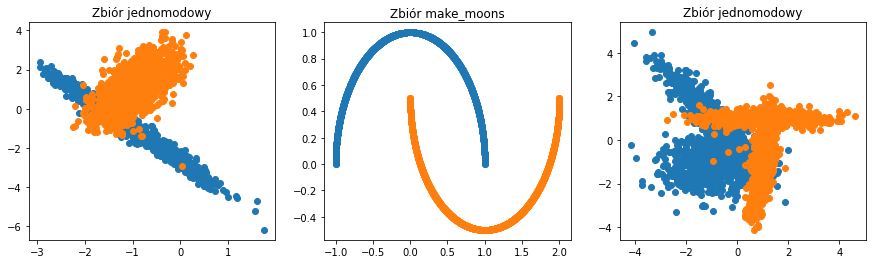

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.scatter(x1[y1==0,0], x1[y1==0,1])
ax1.scatter(x1[y1==1,0], x1[y1==1,1])
ax1.set_title('Zbiór jednomodowy')

ax2.scatter(x2[y2==0,0], x2[y2==0,1])
ax2.scatter(x2[y2==1,0], x2[y2==1,1])
ax2.set_title('Zbiór make_moons')

ax3.scatter(x3[y3==0,0], x3[y3==0,1])
ax3.scatter(x3[y3==1,0], x3[y3==1,1])
ax3.set_title('Zbiór wielomodowy')
plt.show()

## Implementacja drzew decyzyjnych

In [6]:
class DecisionTreeImplementation:

    def fit(self, x, y, max_depth=None):
        self.max_depth = max_depth
        self.n_classes_ = 2
        self.tree_ = self.grow_tree(x, y)

    def grow_tree(self, x, y, depth=0):
        
        if self.entropy(y) == 0:
            if type(y[0]) is np.ndarray:
                return {'class': y[0][0]}
            else:
                return {'class': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            feature1 = 0
            feature0 = 0
            for i in y:
                if i==1:
                    feature1 += 1
                else:
                    feature0 += 1 
            return {'class': 1 if feature1 > feature0 else 0}

        best_feature, best_threshold = self.best_split(x, y)

        left_indices = x[:, best_feature] < best_threshold
        right_indices = x[:, best_feature] >= best_threshold

        left_tree = self.grow_tree(x[left_indices], y[left_indices], depth + 1)
        right_tree = self.grow_tree(x[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature,
                'threshold': best_threshold,
                'left': left_tree,
                'right': right_tree}

    def best_split(self, x, y):
        n_samples, n_features = x.shape
        best_info_gain = -1
        best_feature = None
        best_threshold = None
        
        entropy_tree = self.entropy(y)

        for feature in range(n_features):
            thresholds = np.linspace(min(x[:, feature]), max(x[:, feature]), 100)
            for threshold in thresholds:
                left_indices = x[:, feature] < threshold
                right_indices = x[:, feature] >= threshold

                delta_gain = entropy_tree - (np.sum(left_indices) / n_samples * self.entropy(y[left_indices]) + np.sum(right_indices) / n_samples * self.entropy(y[right_indices]))

                if delta_gain > best_info_gain:
                    best_info_gain = delta_gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def entropy(self, y):
        n_samples = len(y)

        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / n_samples

        return -np.sum(probabilities * np.log2(probabilities))

    def predict(self, X):
        return [self.predict_tree(x, self.tree_) for x in X]

    def predict_tree(self, x, tree):
        if 'class' in tree:
            return tree['class']
        else:
            if x[tree['feature']] < tree['threshold']:
                return self.predict_tree(x, tree['left'])
            else:
                return self.predict_tree(x, tree['right'])

## Porównanie własnej implementacji z drzewem decyzyjnym z sklearn

### Zbiór jednomodowy

Nieograniczona głębokość

In [162]:
Tree1i = DecisionTreeImplementation()
Tree1i.fit(x_train1, y_train1)
Tree1i_pred = Tree1i.predict(x_test1)

In [8]:
Tree1s = tree.DecisionTreeClassifier()
Tree1s.fit(x_train1, y_train1)
Tree1s_pred = Tree1s.predict(x_test1)

Własna implementacja:
accuracy: 0.8963893249607535
sensitivity: 0.89375
specificity: 0.8990536277602523


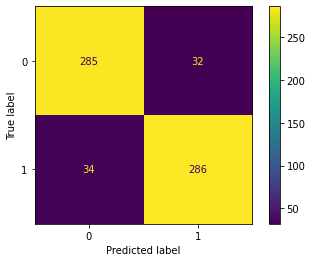

In [9]:
print('Własna implementacja:')
metrics(y_test1, Tree1i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


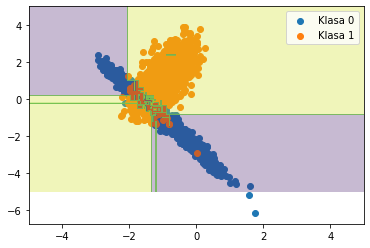

In [10]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree1i, x1, y1)

Implementacja sklearn:
accuracy: 0.8869701726844584
sensitivity: 0.884375
specificity: 0.889589905362776


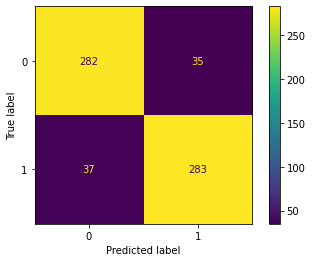

In [11]:
print('Implementacja sklearn:')
metrics(y_test1, Tree1s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


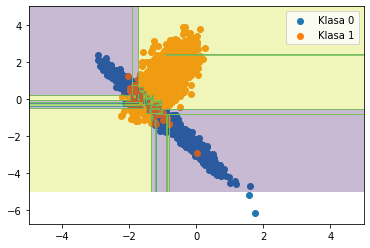

In [12]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree1s, x1, y1)

Własna implementacja radzi sobie lepiej na tym zbiorze przy nieograniczonej głębokości.

Głębokość równa ilości cech/równej całkowitej ilości klastrów.

In [13]:
Tree2i = DecisionTreeImplementation()
Tree2i.fit(x_train1, y_train1, max_depth=2)
Tree2i_pred = Tree1i.predict(x_test1)

In [14]:
Tree2s = tree.DecisionTreeClassifier(max_depth=2)
Tree2s.fit(x_train1, y_train1)
Tree2s_pred = Tree1s.predict(x_test1)

Własna implementacja:
accuracy: 0.8963893249607535
sensitivity: 0.89375
specificity: 0.8990536277602523


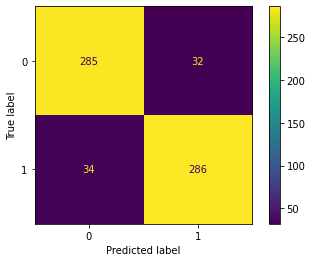

In [15]:
print('Własna implementacja:')
metrics(y_test1, Tree2i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


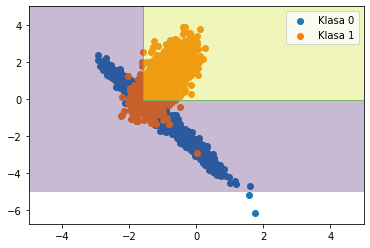

In [16]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree2i, x1, y1)

Implementacja sklearn:
accuracy: 0.8869701726844584
sensitivity: 0.884375
specificity: 0.889589905362776


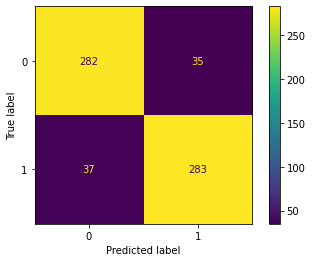

In [17]:
print('Implementacja sklearn:')
metrics(y_test1, Tree2s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


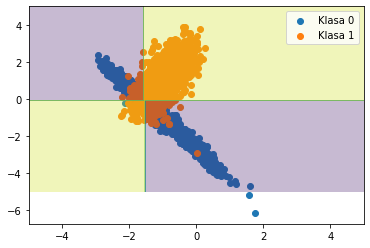

In [18]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree2s, x1, y1)

Własna implementacja radzi sobie lepiej na tym zbiorze przy głebokości równej 2.

### Zbiór make_moons

Nieograniczona głębokość

In [19]:
Tree3i = DecisionTreeImplementation()
Tree3i.fit(x_train2, y_train2)
Tree3i_pred = Tree3i.predict(x_test2)

In [20]:
Tree3s = tree.DecisionTreeClassifier()
Tree3s.fit(x_train2, y_train2)
Tree3s_pred = Tree3s.predict(x_test2)

Własna implementacja:
accuracy: 1.0
sensitivity: 1.0
specificity: 1.0


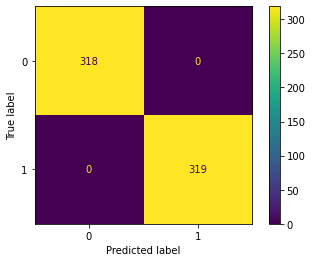

In [21]:
print('Własna implementacja:')
metrics(y_test2, Tree3i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


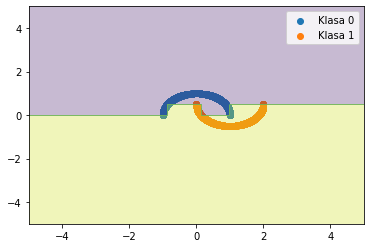

In [22]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree3i, x2, y2)

Implementacja sklearn:
accuracy: 1.0
sensitivity: 1.0
specificity: 1.0


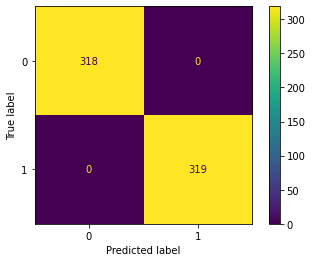

In [23]:
print('Implementacja sklearn:')
metrics(y_test2, Tree3s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


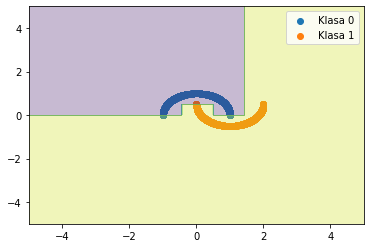

In [24]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree3s, x2, y2)

Obie implementacje radzą sobie równie dobrze na tym zbiorze przy nieograniczonej głębokości.

Głębokość równa ilości cech/ilości klastrów.

In [25]:
Tree4i = DecisionTreeImplementation()
Tree4i.fit(x_train2, y_train2, max_depth=2)
Tree4i_pred = Tree4i.predict(x_test2)

In [26]:
Tree4s = tree.DecisionTreeClassifier(max_depth=2)
Tree4s.fit(x_train2, y_train2)
Tree4s_pred = Tree4s.predict(x_test2)

Własna implementacja:
accuracy: 0.8241758241758241
sensitivity: 0.6489028213166145
specificity: 1.0


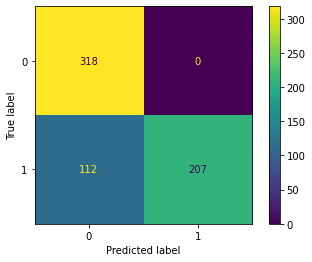

In [27]:
print('Własna implementacja:')
metrics(y_test2, Tree4i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


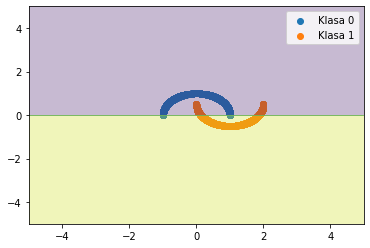

In [28]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree4i, x2, y2)

Implementacja sklearn:
accuracy: 0.9073783359497645
sensitivity: 0.815625
specificity: 1.0


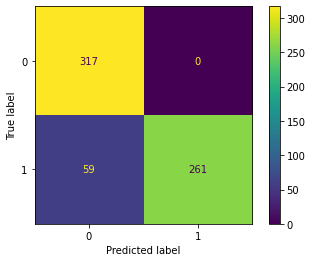

In [29]:
print('Implementacja sklearn:')
metrics(y_test1, Tree4s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


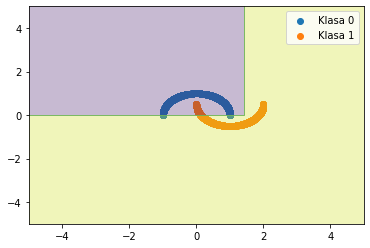

In [30]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree4s, x2, y2)

W tym przypadku, implementacja z sklearn radzi sobie lepiej.

### Zbiór wielomodowy

Nieograniczona głębokość

In [31]:
Tree5i = DecisionTreeImplementation()
Tree5i.fit(x_train3, y_train3)
Tree5i_pred = Tree5i.predict(x_test3)

In [32]:
Tree5s = tree.DecisionTreeClassifier()
Tree5s.fit(x_train3, y_train3)
Tree5s_pred = Tree5s.predict(x_test3)

Własna implementacja:
accuracy: 0.9042386185243328
sensitivity: 0.896551724137931
specificity: 0.9119496855345912


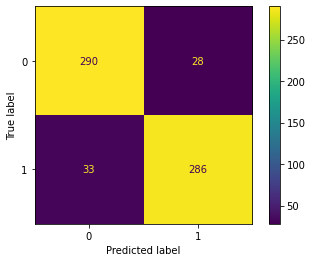

In [33]:
print('Własna implementacja:')
metrics(y_test3, Tree5i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


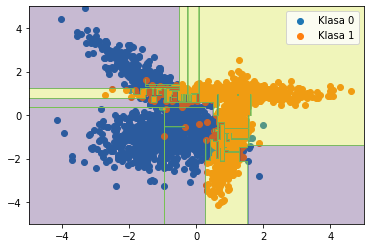

In [34]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree5i, x3, y3)

Implementacja sklearn:
accuracy: 0.8963893249607535
sensitivity: 0.877742946708464
specificity: 0.9150943396226415


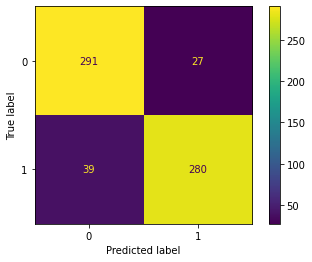

In [35]:
print('Implementacja sklearn:')
metrics(y_test3, Tree5s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


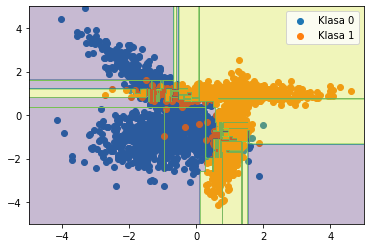

In [36]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree5s, x3, y3)

W tym przypadku, własna implementacja poradziła sobie lepiej.

Głębokość równa ilości cech

In [37]:
Tree6i = DecisionTreeImplementation()
Tree6i.fit(x_train3, y_train3, max_depth=2)
Tree6i_pred = Tree6i.predict(x_test3)

In [38]:
Tree6s = tree.DecisionTreeClassifier(max_depth=2)
Tree6s.fit(x_train3, y_train3)
Tree6s_pred = Tree6s.predict(x_test3)

Własna implementacja:
accuracy: 0.8838304552590267
sensitivity: 0.8056426332288401
specificity: 0.9622641509433962


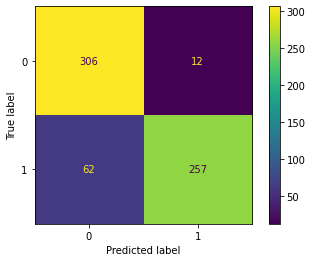

In [39]:
print('Własna implementacja:')
metrics(y_test3, Tree6i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


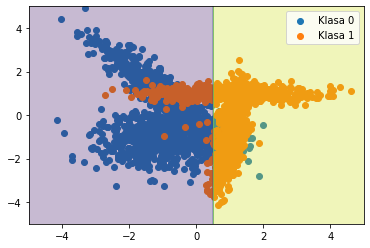

In [40]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree6i, x3, y3)

Implementacja sklearn:
accuracy: 0.8838304552590267
sensitivity: 0.8056426332288401
specificity: 0.9622641509433962


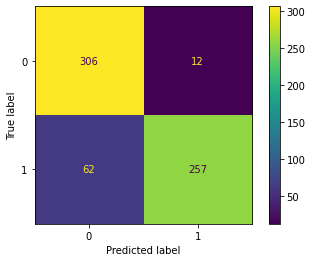

In [41]:
print('Implementacja sklearn:')
metrics(y_test3, Tree6s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


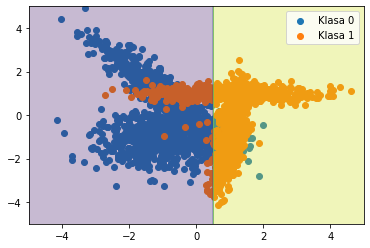

In [42]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree6s, x3, y3)

W tym przypadku, obie wersje poradziły sobie równie dobrze.

Głębokość równa ilości klastrów

In [43]:
Tree7i = DecisionTreeImplementation()
Tree7i.fit(x_train3, y_train3, max_depth=4)
Tree7i_pred = Tree7i.predict(x_test3)

In [44]:
Tree7s = tree.DecisionTreeClassifier(max_depth=4)
Tree7s.fit(x_train3, y_train3)
Tree7s_pred = Tree7s.predict(x_test3)

Własna implementacja:
accuracy: 0.9403453689167975
sensitivity: 0.9184952978056427
specificity: 0.9622641509433962


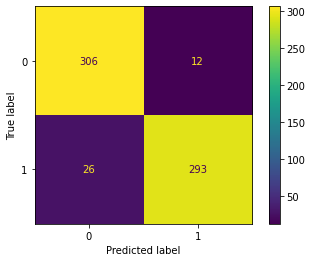

In [45]:
print('Własna implementacja:')
metrics(y_test3, Tree7i_pred)

Powierzchnia decyzyjna dla własnego klasyfikatora


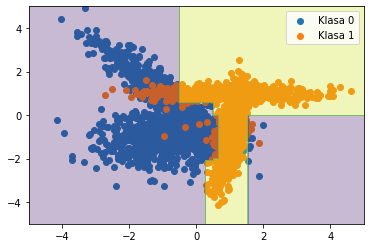

In [46]:
print('Powierzchnia decyzyjna dla własnego klasyfikatora')
surface(Tree7i, x3, y3)

Implementacja sklearn:
accuracy: 0.9466248037676609
sensitivity: 0.9435736677115988
specificity: 0.949685534591195


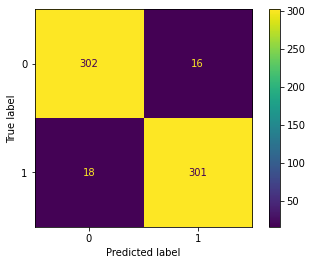

In [47]:
print('Implementacja sklearn:')
metrics(y_test3, Tree7s_pred)

Powierzchnia decyzyjna dla implementacji z sklearn


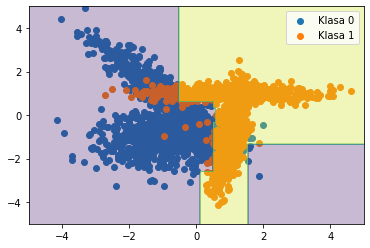

In [48]:
print('Powierzchnia decyzyjna dla implementacji z sklearn')
surface(Tree7s, x3, y3)

Implementacja z sklearn poradziła sobie lepiej na tym zbiorze.

### Porównanie czasu

In [7]:
start1 = time.time()
tree_time = DecisionTreeImplementation()
for i in range(100):
    tree_time.fit(x_train1, y_train1)
    tree_time.predict(x_test1)
end1 = time.time()
print('czas wykonania dla własnej implementacji', end1-start1)

czas wykonania dla własnej implementacji 296.64026856422424


In [8]:
start2 = time.time()
tree_time2 = tree.DecisionTreeClassifier()
for i in range(100):
    tree_time2.fit(x_train1, y_train1)
    tree_time2.predict(x_test1)
end2 = time.time()
print('czas wykonania dla implementacji z sklearn:', end2-start2)

czas wykonania dla implementacji z sklearn: 0.37590956687927246


Czas wykonania własnej implementacji jest znacznie dłuższy od implementacji sklearn.

## Analiza zbioru HTRU2

In [49]:
# fetch dataset 
htru2 = fetch_ucirepo(id=372) 
  
# data (as pandas dataframes) 
x = htru2.data.features 
y = htru2.data.targets 

In [50]:
x.isnull().sum()

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
dtype: int64

In [56]:
x

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=254448, stratify=y)

In [73]:
parameters = {'criterion':['entropy', 'log_loss', 'gini'], 'max_depth':[i for i in range(1, 7)], 'min_samples_split':[i for i in range(2, 10)], 'min_samples_leaf':[i for i in range(2, 5)]}

tree_htru2 = tree.DecisionTreeClassifier()
gridsearch = GridSearchCV(tree_htru2, parameters, n_jobs=-1)
gridsearch.fit(x_train, y_train)

gridsearch.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

In [74]:
best_tree = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)
best_tree.fit(x_train, y_train)
best_tree_pred = best_tree.predict(x_test)

accuracy: 0.983463687150838
sensitivity: 0.8682926829268293
specificity: 0.995079950799508


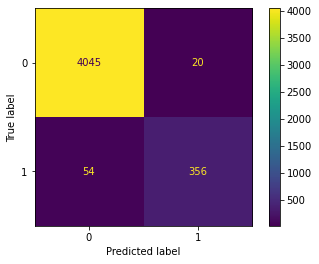

In [75]:
metrics(y_test, best_tree_pred)

## Analiza wpływu głębokości drzewa na jego skuteczność

In [167]:
czas, accuracy = [], []

for depth in range(1,10):
    tree_time = tree.DecisionTreeClassifier(max_depth=depth)

    start = time.time()
    for i in range(10):
        tree_time.fit(x_train, y_train)
        tree_time.predict(x_test)
    end = time.time()
    czas.append(end-start)
    accuracy.append(accuracy_score(y_test, tree_time.predict(x_test)))

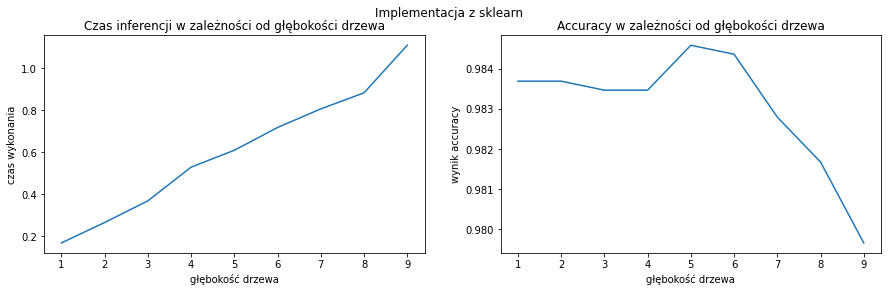

In [168]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.plot(range(1,10), czas)
ax1.set_title('Czas inferencji w zależności od głębokości drzewa')
ax1.set_xlabel('głębokość drzewa')
ax1.set_ylabel('czas wykonania')

ax2.plot(range(1,10), accuracy)
ax2.set_title('Accuracy w zależności od głębokości drzewa')
ax2.set_xlabel('głębokość drzewa')
ax2.set_ylabel('wynik accuracy')

fig.suptitle('Implementacja z sklearn')
plt.show()

In [164]:
czas, accuracy = [], []

x_train_arr = np.array(x_train, dtype=np.int64)
y_train_arr = np.array(y_train, dtype=np.int64)
x_test_arr = np.array(x_test, dtype=np.int64)
y_test_arr = np.array(y_test, dtype=np.int64)

for depth in range(1,10):
    start = time.time()
    for i in range(10):
        tree_time1 = DecisionTreeImplementation()
        tree_time1.fit(x_train_arr, y_train_arr, max_depth=depth)
        pred = tree_time1.predict(x_test_arr)
    end = time.time()
    czas.append(end-start)
    accuracy.append(accuracy_score(y_test_arr, pred))

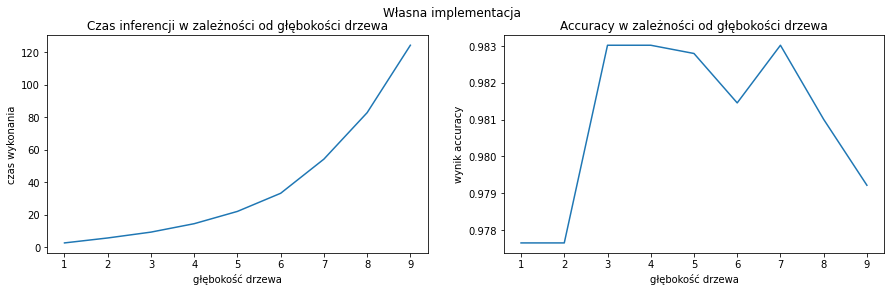

In [166]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.plot(range(1,10), czas)
ax1.set_title('Czas inferencji w zależności od głębokości drzewa')
ax1.set_xlabel('głębokość drzewa')
ax1.set_ylabel('czas wykonania')

ax2.plot(range(1,10), accuracy)
ax2.set_title('Accuracy w zależności od głębokości drzewa')
ax2.set_xlabel('głębokość drzewa')
ax2.set_ylabel('wynik accuracy')

fig.suptitle('Własna implementacja')
plt.show()

Czy wybierając cel dla pierwszej
 sondy mającej za zadanie zbadać pulsar z bliska uzasadniona jest optymalizacja czasu uczenia
 i ewaluacji poprzez poszukiwanie optymalnej głębokości drzewa?

 Wybierając cel dla pierwszej sondy mającej za zadanie zbadać pulsar z bliska czas uczenia i ewaluacji nie jest aż tak ważny, ponieważ sonda będzie leciała na tyle długo, aby zdążyła podjąć decyzję na podstawie modelu.